<a href="https://colab.research.google.com/github/vggd18/telecom-churn-project/blob/feature%2Fboost-kan-mitra/experiments/boosting_kan_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# 1. SETUP E PREPARAÇÃO DE DADOS
# ==============================================================================

from google.colab import drive
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Montar Drive (opcional, se estiver salvando lá)
drive.mount('/content/drive')

# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/boost-kan-mitra

# Instalar dependências se necessário (Optuna é essencial agora)
!pip install -q xgboost pykan optuna

# Setup do path para reconhecer seus módulos locais
sys.path.append('.')

# --- 1.1 Baixar Dados (se não existirem) ---
import kagglehub
import shutil

raw_path = "data/raw/telecom_churn.csv"
if not os.path.exists(raw_path):
    print("⬇️ Baixando dataset do Kaggle...")
    path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
    os.makedirs("data/raw", exist_ok=True)
    shutil.copy(os.path.join(path, "customer_churn_telecom_services.csv"), raw_path)
    print("✅ Dataset baixado e movido.")
else:
    print("✅ Dataset já existe.")

# --- 1.2 Rodar Pipeline de Pré-processamento ---
# Garante que X_train, X_val, etc. estejam criados e atualizados conforme
print("⚙️ Executando pipeline de dados...")
!python scripts/prepare_data.py

Mounted at /content/drive
Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 214 (delta 4), reused 3 (delta 3), pack-reused 206 (from 1)
Receiving objects: 100% (214/214), 6.46 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/telecom-churn-project
Branch 'feature/boost-kan-mitra' set up to track remote branch 'feature/boost-kan-mitra' from 'origin'.
Switched to a new branch 'feature/boost-kan-mitra'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.1 MB/s eta 0:00:00
⬇️ Baixando dataset do Kaggle...


100%|██████████| 112k/112k [00:00<00:00, 42.8MB/s]

Extracting files...
✅ Dataset baixado e movido.
⚙️ Executando pipeline de dados...


🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [2]:
# ==============================================================================
# 2. CARREGAMENTO DOS DADOS (TREINO E VALIDAÇÃO)
# ==============================================================================
DATA_DIR = 'data/processed'

# Carregamos apenas o necessário para otimização
X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val   = np.load(f'{DATA_DIR}/X_val.npy')
y_val   = np.load(f'{DATA_DIR}/y_val.npy')

print(f"✅ Dados em memória para Optuna:")
print(f"   Train: {X_train.shape} (Balanceado)")
print(f"   Val:   {X_val.shape} (Balanceado)")

✅ Dados em memória para Optuna:
   Train: (5162, 30) (Balanceado)
   Val:   (2580, 30) (Balanceado)


In [3]:
# ==============================================================================
# 3. OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA)
# ==============================================================================
import optuna
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from src.metrics import calculate_ks

# Configurar verbosidade do Optuna para não poluir o output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Objective: Gradient Boosting (sklearn) ---
def objective_gb(trial):
    # Espaço de busca (Baseado no Slide 28 + Boas práticas)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'random_state': 42
    }

    # Treino e Validação
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    # Métrica: KS na Validação
    probs_val = model.predict_proba(X_val)[:, 1]
    ks, _, _ = calculate_ks(y_val, probs_val)

    return ks

# --- Objective: XGBoost ---
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500), # Mais alto pois tem early stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 20
    }

    # Fit com Early Stopping usando Validação
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Métrica: KS na Validação
    probs_val = model.predict_proba(X_val)[:, 1]
    ks, _, _ = calculate_ks(y_val, probs_val)

    return ks

In [5]:
# ==============================================================================
# 4. EXECUTANDO A OTIMIZAÇÃO
# ==============================================================================
N_TRIALS = 50 # Ajuste conforme seu tempo disponível (30-50 é bom)

print(f"🚀 Iniciando otimização Gradient Boosting ({N_TRIALS} trials)...")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=N_TRIALS)

print(f"🚀 Iniciando otimização XGBoost ({N_TRIALS} trials)...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)

print("\n" + "="*40)
print("🏆 RESULTADOS DA OTIMIZAÇÃO (VALIDAÇÃO)")
print("="*40)
print(f"Gradient Boosting -> Melhor KS Val: {study_gb.best_value:.4f}")
print(f"XGBoost           -> Melhor KS Val: {study_xgb.best_value:.4f}")

🚀 Iniciando otimização Gradient Boosting (50 trials)...
🚀 Iniciando otimização XGBoost (50 trials)...

🏆 RESULTADOS DA OTIMIZAÇÃO (VALIDAÇÃO)
Gradient Boosting -> Melhor KS Val: 0.5651
XGBoost           -> Melhor KS Val: 0.5659


In [4]:
# ==============================================================================
# 3.1 OTIMIZAÇÃO DE HIPERPARÂMETROS (KAN)
# ==============================================================================
# Importar classe KAN do seu projeto
from models.kan import KANModel

# --- ALTERAÇÃO MÍNIMA: Carregar validação real (desbalanceada) para a métrica do Optuna ---
try:
    X_val_opt = np.load(f'{DATA_DIR}/X_val_imb.npy')
    y_val_opt = np.load(f'{DATA_DIR}/y_val_imb.npy')
except:
    # Fallback caso não tenha rodado o prepare_data novo (usa o balanceado mesmo)
    X_val_opt = X_val
    y_val_opt = y_val
# ------------------------------------------------------------------------------------------

def objective_kan(trial):
    # KAN é mais lento, então sejamos conservadores no espaço de busca
    input_dim = X_train.shape[1]

    # Sugerir arquitetura (Largura da camada oculta)
    hidden_dim = trial.suggest_int('hidden_dim', 4, 16)

    params = {
        'width': [input_dim, hidden_dim, 1],
        'grid': trial.suggest_int('grid', 3, 8),
        'k': 3,
        'lr': trial.suggest_float('lr', 0.001, 0.1, log=True),
        'lamb': trial.suggest_float('lamb', 0.001, 0.1, log=True),
        'steps': 50,
        'random_state': 42
    }

    # Instanciar e Treinar
    try:
        # Nota: O build do KAN no seu código espera width, grid, k
        model = KANModel()
        model.build(width=params['width'], grid=params['grid'], k=params['k'])

        model.train(
            X_train, y_train, X_val, y_val,
            steps=params['steps'],
            lr=params['lr'],
            lamb=params['lamb']
        )

        # Avaliar (USANDO DADOS DESBALANCEADOS PARA MÉTRICA REAL)
        probs_val = model.predict_proba(X_val_opt)
        ks, _, _ = calculate_ks(y_val_opt, probs_val)
        return ks

    except Exception as e:
        print(f"⚠️ Trial KAN falhou: {e}")
        return 0.0 # Penaliza falhas

# Executar Otimização (Menos trials pq KAN é lento)
print("🚀 Iniciando otimização KAN (pode demorar)...")
study_kan = optuna.create_study(direction='maximize')
study_kan.optimize(objective_kan, n_trials=20) # 20 trials é suficiente para sentir o modelo

print(f"🏆 Melhor KS KAN (Val): {study_kan.best_value:.4f}")

🚀 Iniciando otimização KAN (pode demorar)...
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.06e-01 | test_loss: 4.05e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:38<00:00,  1.29it


saving model version 0.1
✅ Treino KAN finalizado: 38.88s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.76e-01 | test_loss: 4.72e-01 | reg: 2.79e+01 | : 100%|█| 50/50 [00:27<00:00,  1.81it


saving model version 0.1
✅ Treino KAN finalizado: 27.64s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.98e-01 | test_loss: 4.96e-01 | reg: 1.78e+01 | : 100%|█| 50/50 [00:23<00:00,  2.09it


saving model version 0.1
✅ Treino KAN finalizado: 23.94s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.01e-01 | test_loss: 4.00e-01 | reg: 5.74e+00 | : 100%|█| 50/50 [00:24<00:00,  2.07it


saving model version 0.1
✅ Treino KAN finalizado: 24.20s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 3.90e-01 | test_loss: 4.00e-01 | reg: 1.28e+01 | : 100%|█| 50/50 [00:26<00:00,  1.90it


saving model version 0.1
✅ Treino KAN finalizado: 26.28s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 3.99e-01 | test_loss: 4.05e-01 | reg: 1.51e+01 | : 100%|█| 50/50 [00:23<00:00,  2.10it


saving model version 0.1
✅ Treino KAN finalizado: 23.79s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.03e-01 | test_loss: 4.01e-01 | reg: 7.53e+00 | : 100%|█| 50/50 [00:18<00:00,  2.67it


saving model version 0.1
✅ Treino KAN finalizado: 18.75s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.55e-01 | test_loss: 4.52e-01 | reg: 1.37e+01 | : 100%|█| 50/50 [00:17<00:00,  2.89it


saving model version 0.1
✅ Treino KAN finalizado: 17.34s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.38e-01 | test_loss: 4.34e-01 | reg: 3.26e+01 | : 100%|█| 50/50 [00:32<00:00,  1.53it


saving model version 0.1
✅ Treino KAN finalizado: 32.76s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.41e-01 | test_loss: 4.35e-01 | reg: 3.12e+01 | : 100%|█| 50/50 [00:32<00:00,  1.55it


saving model version 0.1
✅ Treino KAN finalizado: 32.22s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.99e-01 | test_loss: 4.99e-01 | reg: 2.53e+00 | : 100%|█| 50/50 [00:28<00:00,  1.73it


saving model version 0.1
✅ Treino KAN finalizado: 28.97s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 3.88e-01 | test_loss: 3.98e-01 | reg: 1.64e+01 | : 100%|█| 50/50 [00:31<00:00,  1.59it


saving model version 0.1
✅ Treino KAN finalizado: 31.47s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.87e-01 | test_loss: 5.01e-01 | reg: 3.19e+00 | : 100%|█| 50/50 [00:16<00:00,  2.95it


saving model version 0.1
✅ Treino KAN finalizado: 16.98s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 3.94e-01 | test_loss: 3.99e-01 | reg: 2.15e+01 | : 100%|█| 50/50 [00:23<00:00,  2.17it


saving model version 0.1
✅ Treino KAN finalizado: 23.12s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.93e-01 | test_loss: 4.93e-01 | reg: 5.33e+00 | : 100%|█| 50/50 [00:33<00:00,  1.51it


saving model version 0.1
✅ Treino KAN finalizado: 33.12s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 3.94e-01 | test_loss: 3.96e-01 | reg: 9.52e+00 | : 100%|█| 50/50 [00:17<00:00,  2.94it


saving model version 0.1
✅ Treino KAN finalizado: 17.03s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.01e-01 | test_loss: 4.01e-01 | reg: 9.14e+00 | : 100%|█| 50/50 [00:15<00:00,  3.21it


saving model version 0.1
✅ Treino KAN finalizado: 15.61s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.03e-01 | test_loss: 4.04e-01 | reg: 1.09e+01 | : 100%|█| 50/50 [00:16<00:00,  2.96it


saving model version 0.1
✅ Treino KAN finalizado: 16.91s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 4.38e-01 | test_loss: 4.35e-01 | reg: 5.05e+00 | : 100%|█| 50/50 [00:13<00:00,  3.62it


saving model version 0.1
✅ Treino KAN finalizado: 13.83s
checkpoint directory created: ./model
saving model version 0.0
🚀 Treinando KAN...


| train_loss: 5.00e-01 | test_loss: 5.03e-01 | reg: 7.33e+00 | : 100%|█| 50/50 [00:27<00:00,  1.82it

saving model version 0.1
✅ Treino KAN finalizado: 27.48s
🏆 Melhor KS KAN (Val): 0.5682


In [6]:
# ==============================================================================
# 5. TREINAMENTO FINAL E AVALIAÇÃO (USANDO SCRIPTS)
# ==============================================================================

# Criar pasta de configs se não existir
os.makedirs('configs', exist_ok=True)

# --- 5.1 Preparar Configs ---
# Gradient Boosting
best_params_gb = study_gb.best_params
# XGBoost (precisamos adicionar o early_stopping_rounds manualmente pois não foi otimizado)
best_params_xgb = study_xgb.best_params
best_params_xgb['early_stopping_rounds'] = 20

# Salvar JSONs
with open('configs/best_gb.json', 'w') as f:
    json.dump(best_params_gb, f, indent=4)

with open('configs/best_xgb.json', 'w') as f:
    json.dump(best_params_xgb, f, indent=4)

print("✅ Configurações otimizadas salvas em 'configs/'")

# --- 5.2 Executar Treinamento Oficial (Salva artefatos em results/) ---
print("\n🔄 Treinando modelos finais e salvando artefatos...")

# Treinar GB
!python scripts/train_model.py --model gb --config configs/best_gb.json --output results/gb_optuna.pkl

# Treinar XGBoost
!python scripts/train_model.py --model xgboost --config configs/best_xgb.json --output results/xgb_optuna.pkl

✅ Configurações otimizadas salvas em 'configs/'

🔄 Treinando modelos finais e salvando artefatos...
📂 Carregando dados de data/processed...
✅ Dados carregados: Train=(5162, 30), Val=(2580, 30), Test=(1760, 30)

🔧 Configuração: {'n_estimators': 216, 'learning_rate': 0.013845627608277762, 'max_depth': 4, 'min_samples_leaf': 51, 'subsample': 0.8054810875520646}
🚀 Treinando GradientBoosting...
✅ Treinamento concluído em 2.40s

✅ Modelo salvo em: results/models/gb_optuna_20251219_112327.pkl
📂 Carregando dados de data/processed...
✅ Dados carregados: Train=(5162, 30), Val=(2580, 30), Test=(1760, 30)

🔧 Configuração: {'n_estimators': 355, 'learning_rate': 0.01858959806194793, 'max_depth': 5, 'subsample': 0.992181904058568, 'colsample_bytree': 0.8339801427414961, 'reg_alpha': 0.0011738273682568756, 'reg_lambda': 0.22323873689990384, 'early_stopping_rounds': 20}
🚀 Treinando XGBoost...
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [11:23:32] WARNING: /workspace/sr

In [7]:
# ==============================================================================
# 5.3 TREINAMENTO FINAL KAN
# ==============================================================================

# Preparar config
best_params_kan = study_kan.best_params

# Reconstruir a lista 'width' pq o Optuna retornou apenas 'hidden_dim'
input_dim = X_train.shape[1]
best_params_kan['width'] = [input_dim, best_params_kan.pop('hidden_dim'), 1]

# Adicionar parâmetros fixos que não otimizamos mas precisamos pro train_model.py
best_params_kan['k'] = 3
best_params_kan['steps'] = 100 # No treino final, damos um pouco mais de steps

# Salvar JSON
with open('configs/best_kan.json', 'w') as f:
    json.dump(best_params_kan, f, indent=4)

print("✅ Config KAN salva.")

# Treinar usando o script
print("\n🔄 Treinando KAN final...")
!python scripts/train_model.py --model kan --config configs/best_kan.json --output results/kan_optuna.pkl --lamb 0.01

✅ Config KAN salva.

🔄 Treinando KAN final...
📂 Carregando dados de data/processed...
✅ Dados carregados: Train=(5162, 30), Val=(2580, 30), Test=(1760, 30)

🔧 Configuração: {'grid': 4, 'lr': 0.043766312408285206, 'lamb': 0.006354393857575986, 'width': [30, 7, 1], 'k': 3, 'steps': 100}
checkpoint directory created: ./model
saving model version 0.0
   ℹ️  Treinando KAN (lr=0.043766312408285206, steps=100, lamb=0.01)
🚀 Treinando KAN...
| train_loss: 3.91e-01 | test_loss: 3.97e-01 | reg: 6.86e+00 | : 100%|█| 100/100 [00:27<00:00,  3.62
saving model version 0.1
✅ Treino KAN finalizado: 27.67s

✅ Modelo salvo em: results/models/kan_optuna_20251219_112406.pkl


In [8]:
# ==============================================================================
# 6. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (CORRIGIDO)
# ==============================================================================
import os

# Função auxiliar CORRIGIDA
def get_latest_model(model_type):
    # Lista todos os modelos na pasta
    files = [f for f in os.listdir('results/models') if f.endswith('.pkl')]

    # Filtra: DEVE conter o model_type MAS se for 'gb', NÃO pode conter 'xgb'
    if model_type == 'gb_optuna':
        files = [f for f in files if model_type in f and 'xgb' not in f]
    else:
        files = [f for f in files if model_type in f]

    if not files:
        print(f"⚠️ Nenhum modelo encontrado para: {model_type}")
        return None

    # Retorna o mais recente
    return os.path.join('results/models', sorted(files)[-1])

# Busca os caminhos corretos agora
path_gb = get_latest_model('gb_optuna')
path_xgb = get_latest_model('xgb_optuna')

# Avalia Gradient Boosting (Check: o caminho impresso deve começar com 'gb_')
if path_gb:
    print(f"\n📊 Avaliando Gradient Boosting: {path_gb}")
    !python scripts/evaluate_model.py --model "{path_gb}" --type gb --output metrics_gb_final.json
else:
    print("\n❌ Modelo Gradient Boosting não encontrado.")

# Avalia XGBoost
if path_xgb:
    print(f"\n📊 Avaliando XGBoost: {path_xgb}")
    !python scripts/evaluate_model.py --model "{path_xgb}" --type xgboost --output metrics_xgb_final.json
else:
    print("\n❌ Modelo XGBoost não encontrado.")



📊 Avaliando Gradient Boosting: results/models/gb_optuna_20251219_112327.pkl
📂 Carregando dados de data/processed...
✅ Modelo carregado: results/models/gb_optuna_20251219_112327.pkl
🔍 Threshold Otimizado: 0.4900

📊 AVALIAÇÃO: GradientBoosting

Dataset    KS       AUROC    Precision  Recall   F1      
-----------------------------------------------------------------
Train      0.6160   0.8847   0.7732     0.8574   0.8132  
Val        0.5651   0.8503   0.7523     0.8357   0.7918  
Test       0.5083   0.8337   0.4973     0.7842   0.6086  

💾 Salvando resultados...
   ✅ JSON salvo em: results/metrics/metrics_gb_final_20251219_112412.json
   📊 Gerando gráficos...
📈 Gráfico KS salvo em: results/figures/metrics_gb_final_20251219_112412_ks.png
📈 Curva ROC salva em: results/figures/metrics_gb_final_20251219_112412_roc.png
📈 Matriz de Confusão salva em: results/figures/metrics_gb_final_20251219_112412_cm.png
   ✅ Gráficos salvos em results/figures/

📊 Avaliando XGBoost: results/models/xgb_optuna


📊 Avaliando KAN: results/models/kan_optuna_20251219_112406.pkl
📂 Carregando dados de data/processed...
checkpoint directory created: ./model
saving model version 0.0
✅ Modelo carregado: results/models/kan_optuna_20251219_112406.pkl
🔍 Threshold Otimizado: 0.6100

📊 AVALIAÇÃO: KAN

Dataset    KS       AUROC    Precision  Recall   F1      
-----------------------------------------------------------------
Train      0.5606   0.8599   0.7327     0.8718   0.7962  
Val        0.5589   0.8521   0.7210     0.8612   0.7849  
Test       0.5182   0.8332   0.4716     0.8504   0.6067  

💾 Salvando resultados...
   ✅ JSON salvo em: results/metrics/metrics_kan_final_20251219_112428.json
   📊 Gerando gráficos...
📈 Gráfico KS salvo em: results/figures/metrics_kan_final_20251219_112428_ks.png
📈 Curva ROC salva em: results/figures/metrics_kan_final_20251219_112428_roc.png
📈 Matriz de Confusão salva em: results/figures/metrics_kan_final_20251219_112428_cm.png
   ✅ Gráficos salvos em results/figures/

🏆 CL

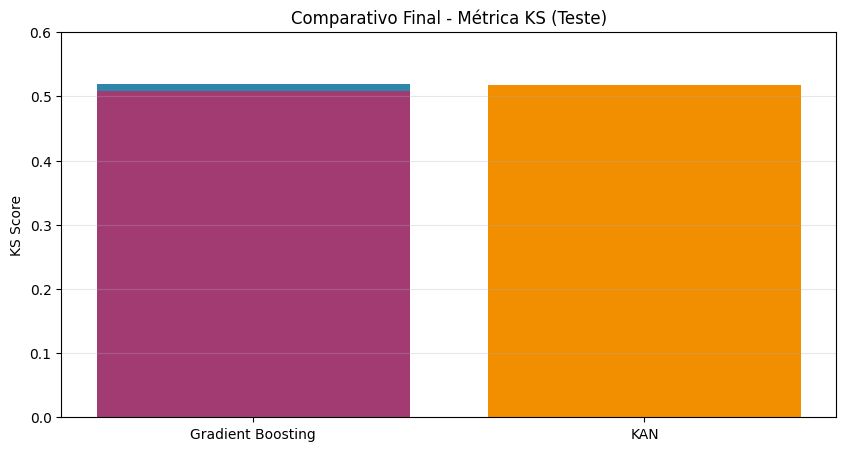

In [9]:
# ==============================================================================
# 6.1 AVALIAÇÃO E COMPARATIVO FINAL (COM KAN)
# ==============================================================================

# Buscar modelo KAN mais recente
def get_latest_kan():
    files = [f for f in os.listdir('results/models') if 'kan' in f and f.endswith('.pkl')]
    if not files: return None
    return os.path.join('results/models', sorted(files)[-1])

path_kan = get_latest_kan()

if path_kan:
    print(f"\n📊 Avaliando KAN: {path_kan}")
    !python scripts/evaluate_model.py --model "{path_kan}" --type kan --output metrics_kan_final.json
else:
    print("❌ Modelo KAN não encontrado.")

# --- Gerar Tabela Comparativa ---
import glob

# Carregar todas as métricas salvas
metrics_files = glob.glob('results/metrics/metrics_*_final_*.json')
results_list = []

for f in metrics_files:
    with open(f, 'r') as file:
        data = json.load(file)
        # Extrair nome do modelo do nome do arquivo
        name = "Unknown"
        if "gb_" in f: name = "Gradient Boosting"
        elif "xgb_" in f: name = "XGBoost"
        elif "kan_" in f: name = "KAN"

        results_list.append({
            'Modelo': name,
            'KS (Teste)': data['test']['ks'],
            'AUROC': data['test']['auroc'],
            'Recall': data['test']['recall'],
            'Precision': data['test']['precision']
        })

df_final = pd.DataFrame(results_list).sort_values(by='KS (Teste)', ascending=False)
print("\n🏆 CLASSIFICAÇÃO FINAL:")
print(df_final)

# Plotar Comparação
plt.figure(figsize=(10, 5))
plt.bar(df_final['Modelo'], df_final['KS (Teste)'], color=['#2E86AB', '#F18F01', '#A23B72'])
plt.title('Comparativo Final - Métrica KS (Teste)')
plt.ylabel('KS Score')
plt.ylim(0, 0.6) # Ajuste conforme necessário
plt.grid(axis='y', alpha=0.3)
plt.show()

In [12]:
from google.colab import files

# Cria um zip da pasta results
!zip -r results_churn.zip results/

# Baixa para o seu PC
files.download('results_churn.zip')

  adding: results/ (stored 0%)
  adding: results/models/ (stored 0%)
  adding: results/models/gb_optuna_20251219_112327.pkl (deflated 69%)
  adding: results/models/kan_optuna_20251219_112406.pkl (deflated 95%)
  adding: results/models/xgb_optuna_20251219_112333.pkl (deflated 72%)
  adding: results/figures/ (stored 0%)
  adding: results/figures/metrics_xgb_final_20251219_112420_ks.png (deflated 15%)
  adding: results/figures/metrics_kan_final_20251219_112428_roc.png (deflated 17%)
  adding: results/figures/metrics_xgb_final_20251219_112420_cm.png (deflated 20%)
  adding: results/figures/metrics_gb_final_20251219_112412_cm.png (deflated 20%)
  adding: results/figures/metrics_gb_final_20251219_112412_roc.png (deflated 17%)
  adding: results/figures/metrics_gb_final_20251219_112412_ks.png (deflated 15%)
  adding: results/figures/metrics_xgb_final_20251219_112420_roc.png (deflated 17%)
  adding: results/figures/metrics_kan_final_20251219_112428_ks.png (deflated 15%)
  adding: results/figure

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>